In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

/home/ian/Projects/work/monk/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [66]:
def compute_unwrapped_pos_from_deltas(traj):
    ref_snap = traj[0]
    ref_pos = ref_snap.particles.position.copy()
    box = freud.box.Box.from_box(ref_snap.configuration.box)
    pos_shape = ref_pos.shape
    pos = np.zeros((len(traj), *pos_shape), dtype=np.float32)
    pos[0] = ref_pos
    for i, snap in enumerate(traj[1:]):
        next_pos = snap.particles.position.copy()
        pos[i+1] = box.wrap(next_pos - ref_pos) + pos[i]
        ref_pos = next_pos

    return pos

def extract_relative_timesteps(traj):
    
    tsteps = np.zeros(len(traj))
    tstep0 = traj[0].log['Simulation/timestep'][0]
    for i in range(len(traj)):
        tsteps[i] = traj[i].log['Simulation/timestep'][0] - tstep0

    return tsteps


def sisf(pos, k=7.14):

    term = k*np.linalg.norm(pos - pos[0], axis=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.mean(np.nan_to_num(np.sin(term)/term, nan=1.0), axis=1)


# Figure 1 - Characterization of systems we analyze

## Compute MSD for systems, A particles, and B particles

In [67]:


for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print("Delta:", delta)

    os.makedirs(project.fn(f"dynamics/delta-{delta}"), exist_ok=True)

    jobs: List[signac.Project.Job] = list(jobs_iter)

    job0 = jobs[0]

    msd = freud.msd.MSD(mode="direct")

    temps = [utils.extract_between(run, "/temp-", "/traj.gsd") for run in glob.glob(job0.fn("runs/*/traj.gsd"))]
    for temp in temps:
        print("Temp:", temp)

        out_file = project.fn(f"dynamics/delta-{delta}/msd-sisf_temp-{temp}.npz")
        if os.path.exists(out_file):
            continue

        acc_msd = []
        acc_sisf = []

        acc_msd_A = []
        acc_sisf_A = []

        acc_msd_B = []
        acc_sisf_B = []

        for job in jobs:

            assert isinstance(job, signac.Project.Job)

            run = sorted(glob.glob(job.fn(f"runs/temp-{temp}/traj.gsd")))[0]
            traj = gsd.hoomd.open(run)[-2000:]  # these runs have 4000 data points
            # later half will have relaxed at least a couple tau alpha

            pos = compute_unwrapped_pos_from_deltas(traj)

            time = extract_relative_timesteps(traj)*project.doc["dt"]

            typeid = traj[0].particles.typeid
            A_mask = typeid == 0
            B_mask = typeid == 1

            msd.compute(pos)
            acc_msd.append(msd.msd)
            acc_sisf.append(sisf(pos))

            msd.compute(pos[:, A_mask])
            acc_msd_A.append(msd.msd)
            acc_sisf_A.append(sisf(pos[:, A_mask]))

            msd.compute(pos[:, B_mask])
            acc_msd_B.append(msd.msd)
            acc_sisf_B.append(sisf(pos[:, B_mask]))

        sys_msd = np.mean(acc_msd, axis=0)
        sys_sisf = np.mean(acc_sisf, axis=0)

        sys_msd_A = np.mean(acc_msd_A, axis=0)
        sys_sisf_A = np.mean(acc_sisf_A, axis=0)

        sys_msd_B = np.mean(acc_msd_A, axis=0)
        sys_sisf_B = np.mean(acc_sisf_A, axis=0)

        np.savez(out_file,
                 msd=sys_msd,
                 sisf=sys_sisf,
                 msd_A=sys_msd_A,
                 sisf_A=sys_sisf_A,
                 msd_B=sys_msd_B,
                 sisf_B=sys_sisf_B)


Delta: 0.0
Temp: 2.00
Temp: 0.45
Temp: 0.67
Temp: 0.75
Temp: 0.80
Temp: 0.58
Temp: 1.40
Temp: 0.55
Temp: 1.80
Temp: 0.53
Temp: 0.61
Temp: 1.00
Temp: 0.90
Temp: 0.49
Temp: 1.20
Temp: 0.70
Temp: 1.60
Temp: 0.47
Temp: 0.51
Temp: 0.64
Delta: 0.1
Temp: 0.67
Temp: 0.80
Temp: 2.26
Temp: 0.94
Temp: 0.56
Temp: 0.73
Temp: 0.61
Temp: 1.00
Temp: 1.51
Temp: 0.69
Temp: 0.88
Temp: 2.51
Temp: 2.01
Temp: 1.13
Temp: 1.76
Temp: 0.59
Temp: 1.25
Temp: 0.64
Temp: 0.77
Temp: 0.84
Delta: 0.2
Temp: 1.46
Temp: 2.60
Temp: 0.76
Temp: 0.80
Temp: 1.95
Temp: 0.83
Temp: 0.94
Temp: 0.89
Temp: 1.04
Temp: 0.73
Temp: 1.63
Temp: 1.14
Temp: 2.28
Temp: 0.99
Temp: 1.09
Temp: 0.86
Temp: 1.30
Temp: 2.93
Temp: 1.22
Temp: 3.25
Delta: 0.3
Temp: 1.98
Temp: 1.47
Temp: 1.34
Temp: 1.54
Temp: 3.51
Temp: 1.41
Temp: 2.64
Temp: 2.20
Temp: 1.65
Temp: 1.03
Temp: 3.08
Temp: 0.99
Temp: 3.95
Temp: 1.27
Temp: 1.08
Temp: 1.12
Temp: 1.21
Temp: 4.39
Temp: 1.76
Temp: 1.16
Delta: 0.4
Temp: 1.92
Temp: 5.03
Temp: 1.82
Temp: 4.40
Temp: 3.77
Temp: 1.42

In [61]:
run

'/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/runs/temp-0.45/traj.gsd'

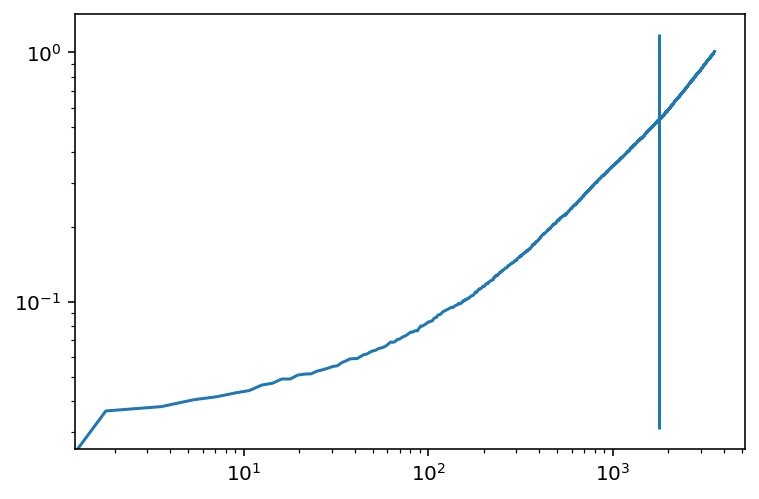

In [55]:
plt.plot(time, msd.msd)
plt.yscale('log')
plt.xscale('log')
plt.vlines(time[len(time)//2], *plt.ylim())

In [46]:
len(pos)

2000

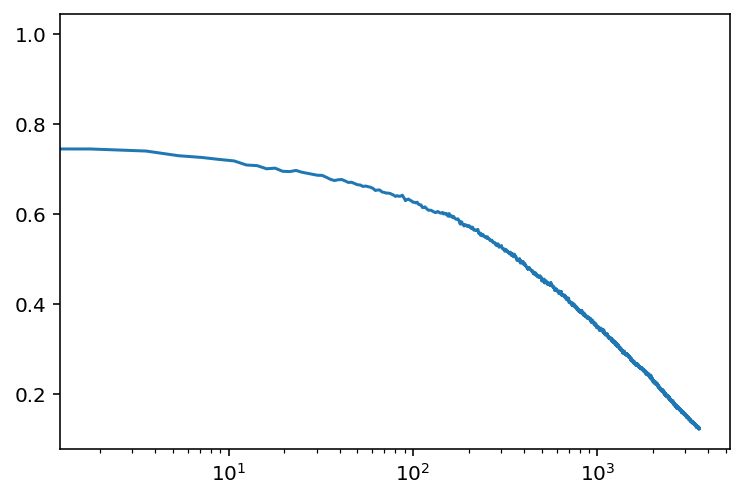

In [54]:
plt.plot(time, sys_sisf)
plt.xscale('log')